# Faulty Air Quality Sensor Challenge 
## Problem definition
AirQo’s air quality sensing network has more than 120 low-cost devices deployed across Uganda; in most cases, these devices are deployed in unmonitored or perilous environments. These low-cost electronic devices are susceptible to breakdown caused by communication malfunction, aging, wear and tear, manufacturing deficiencies, incorrect calibration, mishandling and other external environmental factors. Faults lead to data inaccuracies and data loss, which impacts decisions and policies that could significantly impact people’s lives.
## Problem statement
Device failure detection and monitoring is critical to AirQo’s business; faulty devices need to be identified, isolated and fixed or replaced with urgency. Data received from a device can be used to identify whether the device is working correctly or not.
## Objective
In this challenge, the task is to develop a classification model to identify a device that has an off set fault or not, regardless of the device. The model can be used by AirQo to automatically flag a device that is returning faulty data.

In [54]:
# Necessary Libraries
import pandas as pd 
import numpy as np 
#   modelling
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
# metrics
from sklearn.metrics import accuracy_score, confusion_matrix, confusion_matrix, classification_report, f1_score
import warnings
warnings.filterwarnings("ignore")
# seeding
np.random.seed(123)


In [55]:
#loading dataset
train=pd.read_csv("Airqo_train.csv")
test=pd.read_csv("Airqo_test.csv")
SampleSubmission= pd.read_csv("Airqo_SampleSubmission.csv")
train.shape, test.shape, SampleSubmission.shape

((297177, 7), (127361, 6), (127361, 2))

In [56]:
train.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
0,ID_QF0ZTQJ2SF5Q,2021-11-03 04:06:31,52.58,49.52,17.4,96.0,0
1,ID_4GTK689CNX5S,2021-11-08 18:43:23,35.25,33.40,25.0,75.0,0
2,ID_DL7VVKW9U7XQ,2021-11-07 09:50:33,19.18,23.50,24.9,75.0,0
3,ID_6XQOMBXM2DG3,2022-01-01 18:55:15,19.40,15.48,24.9,70.0,0
4,ID_UQZW9ISJY9QE,2021-11-05 22:23:48,38.30,34.77,20.9,89.0,0


In [57]:
test.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity
0,ID_STL3V9B2OU12,2022-01-28 08:49:41,90.75,114.78,22.2,56.0
1,ID_U2EKAY4SGA94,2022-02-16 21:30:17,56.03,52.18,NaN,NaN
2,ID_UJFLEWQR0U4N,2022-01-24 17:57:18,387.35,346.73,28.1,63.0
3,ID_S2C2GPGA4R5I,2022-01-31 07:07:09,63.17,83.85,21.6,82.0
4,ID_5V2C2ZL221H8,2022-01-31 00:37:05,69.23,53.07,22.7,80.0


In [58]:
SampleSubmission.head()

,ID,Offset_fault
0,ID_STL3V9B2OU12,0
1,ID_U2EKAY4SGA94,0
2,ID_UJFLEWQR0U4N,0
3,ID_S2C2GPGA4R5I,0
4,ID_5V2C2ZL221H8,0


In [59]:
#checking for more info on the dataset/Statistical summaries
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297177 entries, 0 to 297176
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ID                 297177 non-null  object 
 1   Datetime           297177 non-null  object 
 2   Sensor1_PM2.5      293563 non-null  float64
 3   Sensor2_PM2.5      293563 non-null  float64
 4   Temperature        293628 non-null  float64
 5   Relative_Humidity  293628 non-null  float64
 6   Offset_fault       297177 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 15.9+ MB


In [60]:
train.describe(include="all")

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
count,297177,297177,293563.000000,293563.000000,293628.000000,293628.000000,297177.000000
unique,297177,293751,NaN,NaN,NaN,NaN,NaN
top,ID_QF0ZTQJ2SF5Q,2021-11-26 17:23:00,NaN,NaN,NaN,NaN,NaN
freq,1,3,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,40.751195,38.183018,23.316554,78.653623,0.371072
std,NaN,NaN,28.526182,28.647761,3.836971,14.772725,0.483092
min,NaN,NaN,-9.450000,-9.700000,16.700000,27.000000,0.000000
25%,NaN,NaN,22.430000,19.520000,20.400000,68.000000,0.000000
50%,NaN,NaN,36.470000,33.720000,21.900000,84.000000,0.000000
75%,NaN,NaN,49.420000,47.570000,26.300000,91.000000,1.000000


From the above statistical summary,I see some of the following insights:
 - The train data provided ranges from *2021-10-15 16:00:34* to *2022-01-21 07:34:57*
 - There is a high correlation between Sensor1_PM2.5	and Sensor2_PM2.5
 - Minimum recorded temperature is *16.70000* and a maximum *34.90000*
 - The mean temperature recorded is 23.316554	
 - The mean humidity recorded is 78.653623 

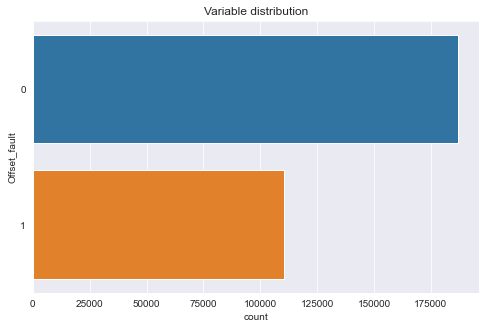

In [61]:
import seaborn as sns 
import matplotlib.pyplot as plt 
plt.figure(figsize=(8,5))
sns.set_style("darkgrid")
sns.countplot(y=train["Offset_fault"])
plt.title("Variable distribution")
plt.show()

In [62]:
#Check for the missing values and weather figure out weather we can impute them or discard the rows
train.isnull().sum(), test.isnull().sum() 

(ID                      0
 Datetime                0
 Sensor1_PM2.5        3614
 Sensor2_PM2.5        3614
 Temperature          3549
 Relative_Humidity    3549
 Offset_fault            0
 dtype: int64,
 ID                       0
 Datetime                 0
 Sensor1_PM2.5            0
 Sensor2_PM2.5            0
 Temperature          88090
 Relative_Humidity    88090
 dtype: int64)

From this view I can conclude that the test dataset has many missing values on 
Temperature and Humidity variables.

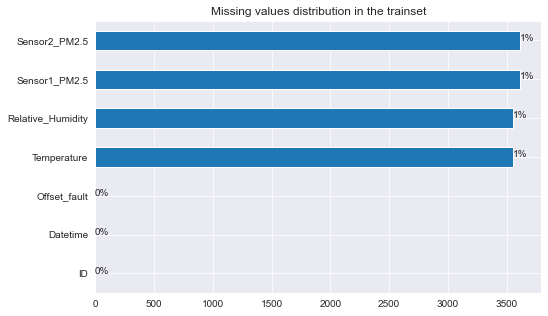

In [63]:
figure = train.isna().sum().sort_values().plot(kind="barh", figsize=(8,5))
plt.title("Missing values distribution in the trainset")
for p in figure.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    figure.annotate(percentage,(x,y)) 

In order to deal with the missing values, For this case I am going to impute them, However it is important for me to find out the correct course for instance the best way to impute the missing values.
Outliers data points will have a significant impact on the mean and hence, in such cases, it is not recommended to use the mean for replacing the missing values. Using mean values for replacing missing values may not create a great model and hence gets ruled out. For symmetric data distribution, I can use the mean value for imputing missing values.

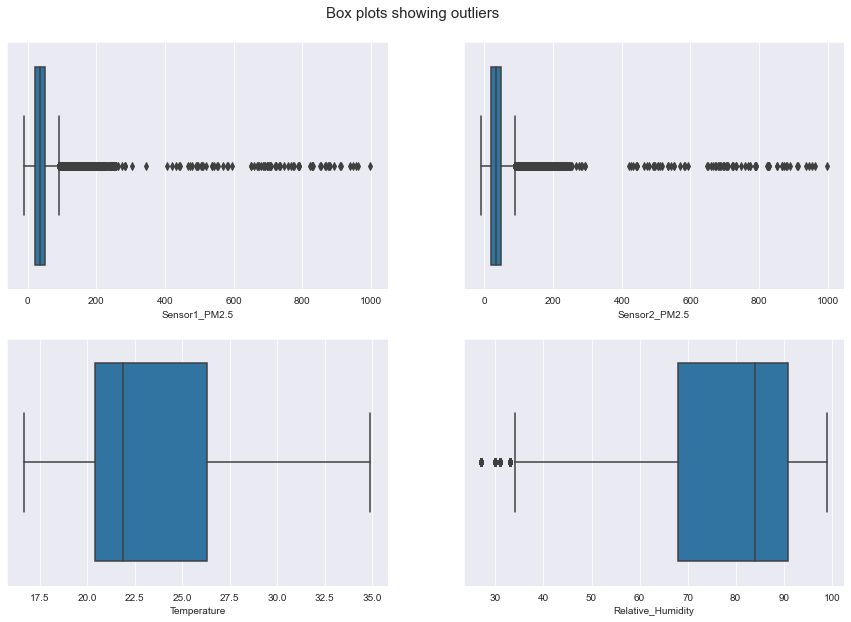

In [64]:
#Subplots/ boxplots to check for possible outliers or symetry
fig, axes= plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))
fig.suptitle('Box plots showing outliers', y= 0.93, fontsize = 15)
for ax, data, name in zip(axes.flatten(), train, ['Sensor1_PM2.5',	'Sensor2_PM2.5',	'Temperature',	'Relative_Humidity']):
  sns.boxplot(train[name], ax = ax)

From the view, its clear that sensor values posses Outliers. Therefore, the best course of action should not include imputing them with the mean, instead, When the data is skewed, it is good to consider using mode or median values for replacing the missing values. For data points such as the Sensor field,I am considering using mode for replacing the values.

In [65]:
train.isnull().sum()

ID                      0
Datetime                0
Sensor1_PM2.5        3614
Sensor2_PM2.5        3614
Temperature          3549
Relative_Humidity    3549
Offset_fault            0
dtype: int64

In [66]:
#Imputing the missing values with mode
for column in train:
    if train[column].isnull().any():
        if(column in train):
            train[column]=train[column].fillna(train[column].mode()[0])
        #else:
            #train[column]=train[column].fillna(train[column].mean)
#train= train.fillna(train.mode())

In [67]:
train.isnull().sum()

ID                   0
Datetime             0
Sensor1_PM2.5        0
Sensor2_PM2.5        0
Temperature          0
Relative_Humidity    0
Offset_fault         0
dtype: int64

In [68]:
#Checking for duplicates 
train.duplicated().any(), test.duplicated().any()


(False, False)

#Feature Engineering


In [126]:
def time_column_generator(time_column, data, to_drop=False):
  '''
  It extracts information from the time column to return a new dataset with 
  new columns consisting of year, month, day, holiday, weekend, hour and minute.

  **Parameters**:
  time_column: str 
      The time column 
  
  data: DataFrame
      The dataframe containing the time column
  
  to_drop: Boolean
      Default is False. If True, drops the original date column

  **Returns**:
  New dataset with new column
  '''
  # Import Datetime module
  from datetime import datetime
  # Extract values of time
  time_values = data[time_column].values

  # Extract month, year, day and day of week from Datetime
  month = [datetime.strptime(value, '%Y-%m-%d %H:%M:%S').month for value in time_values]
  year = [datetime.strptime(value, '%Y-%m-%d %H:%M:%S').year for value in time_values]
  day = [datetime.strptime(value,  '%Y-%m-%d %H:%M:%S').day for value in time_values]
  hour=[datetime.strptime(value, '%Y-%m-%d %H:%M:%S').hour for value in time_values]
  day_of_week = [datetime.strptime(value,  '%Y-%m-%d %H:%M:%S').isoweekday() for value in time_values] 

  # create columns
  data['Month'] = month
  data['Year'] = year
  data['Day'] = day
  data["hour"]=hour
  data['Day_of_week'] = day_of_week

  # drop original column
  if to_drop:
      new_data = data.drop(time_column, axis=1)
  else:
      new_data = data.copy()

  return new_data


In [127]:
train_new = time_column_generator('Datetime', train, True)

In [128]:
train_new.head()

,ID,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault,Month,Year,Day,hour,Day_of_week
0,ID_QF0ZTQJ2SF5Q,52.58,49.52,17.4,96.0,0,11,2021,3,4,3
1,ID_4GTK689CNX5S,35.25,33.40,25.0,75.0,0,11,2021,8,18,1
2,ID_DL7VVKW9U7XQ,19.18,23.50,24.9,75.0,0,11,2021,7,9,7
3,ID_6XQOMBXM2DG3,19.40,15.48,24.9,70.0,0,1,2022,1,18,6
4,ID_UQZW9ISJY9QE,38.30,34.77,20.9,89.0,0,11,2021,5,22,5


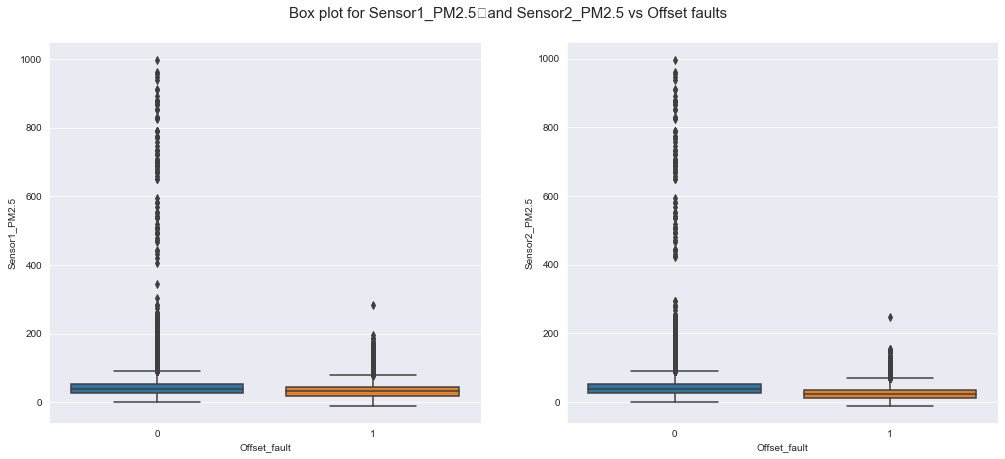

In [129]:
# Box plots for Sensor1_PM2.5	and Sensor2_PM2.5 vs Offset faults
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (17, 7))
fig.suptitle('Box plot for Sensor1_PM2.5	and Sensor2_PM2.5 vs Offset faults', y= 0.95, fontsize = 15)

for ax, data, name in zip(axes.flatten(), train_new, ['Sensor1_PM2.5', 'Sensor2_PM2.5']):
  sns.boxplot(train.Offset_fault, train[name], ax= ax)

<Figure size 1440x864 with 0 Axes>

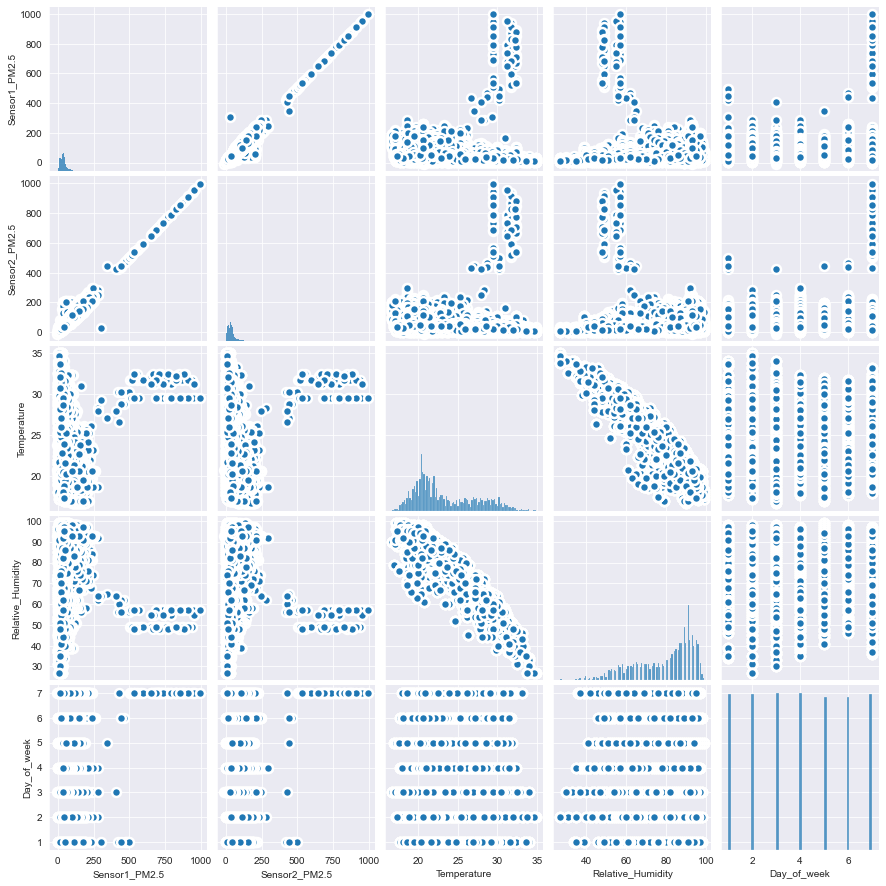

In [130]:
# Type of correlations 
plt.figure(figsize = (20, 12))
num_cols = ['Sensor1_PM2.5',	'Sensor2_PM2.5',	'Temperature',	'Relative_Humidity', "Day_of_week"]
sns.pairplot(train[num_cols], kind="scatter", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

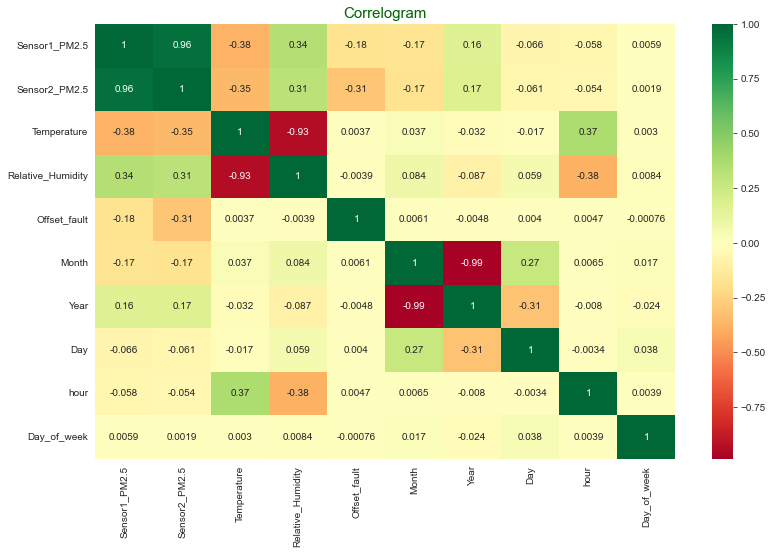

In [131]:
# Quantify correlations
corr = train_new.corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

In [133]:
test_new = time_column_generator('Datetime', test, True)
test_new.head()

,ID,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Month,Year,Day,hour,Day_of_week
0,ID_STL3V9B2OU12,90.75,114.78,22.2,56.0,1,2022,28,8,5
1,ID_U2EKAY4SGA94,56.03,52.18,21.0,92.0,2,2022,16,21,3
2,ID_UJFLEWQR0U4N,387.35,346.73,28.1,63.0,1,2022,24,17,1
3,ID_S2C2GPGA4R5I,63.17,83.85,21.6,82.0,1,2022,31,7,1
4,ID_5V2C2ZL221H8,69.23,53.07,22.7,80.0,1,2022,31,0,1


In [ ]:
test.isnull().sum()

ID                       0
Datetime                 0
Sensor1_PM2.5            0
Sensor2_PM2.5            0
Temperature          88090
Relative_Humidity    88090
dtype: int64

In [91]:
# Fill in missing values with Zeroes
for column in test:
    if test[column].isnull().any():
        if(column in test):
            test[column]=test[column].fillna(test[column].mode()[0])

# Preview engineered test set
test.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity
0,ID_STL3V9B2OU12,2022-01-28 08:49:41,90.75,114.78,22.2,56.0
1,ID_U2EKAY4SGA94,2022-02-16 21:30:17,56.03,52.18,21.0,92.0
2,ID_UJFLEWQR0U4N,2022-01-24 17:57:18,387.35,346.73,28.1,63.0
3,ID_S2C2GPGA4R5I,2022-01-31 07:07:09,63.17,83.85,21.6,82.0
4,ID_5V2C2ZL221H8,2022-01-31 00:37:05,69.23,53.07,22.7,80.0


In [92]:
test.isnull().sum()

ID                   0
Datetime             0
Sensor1_PM2.5        0
Sensor2_PM2.5        0
Temperature          0
Relative_Humidity    0
dtype: int64

# Modelling

In [107]:
## Data splitting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

## Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier,AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Import metrics

## Classification metrics
from sklearn.metrics import classification_report

## Regression metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 


In [114]:
# Selecting the independent variables and the target variable
train_feats = ['Datetime','Sensor1_PM2.5',	'Sensor2_PM2.5',	'Temperature',	'Relative_Humidity',]

X = train[train_feats].fillna(0)  #Train variables
y = train.Offset_fault  #Target variable
# Splitting the data into training and testing sets
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size = 0.7, random_state = 0)
X_val, X_test, y_val, y_test=train_test_split(X_hold, y_hold, test_size=0.5, random_state=0)

In [115]:
# Model trainer
def model_trainer(models, X_train, X_val, y_train, y_val):
    '''
  Trains the model
  '''
  
    for model in models:
        model.fit(X_train, y_train)
        predictions = model.predict(X_val)
        mae = mean_absolute_error(y_val, predictions)
        rmse = mean_squared_error(y_val, predictions, squared=False)
        r2 = r2_score(y_val, predictions)
        print(f'Model {model} , rmse: {rmse}, r2_score: {r2}, mae: {mae}')

In [116]:
# Define models
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
adaboost = AdaBoostClassifier()
gb = GradientBoostingClassifier()
KNN=KNeighborsClassifier()
class_models = [ dt, rf, adaboost, gb,KNN]

In [117]:
# Train and evaluate
model_trainer(class_models, X_train, X_val, y_train, y_val)

ValueError: could not convert string to float: '2022-01-07 02:43:04'

RandomForest is the best classifier based on the results.


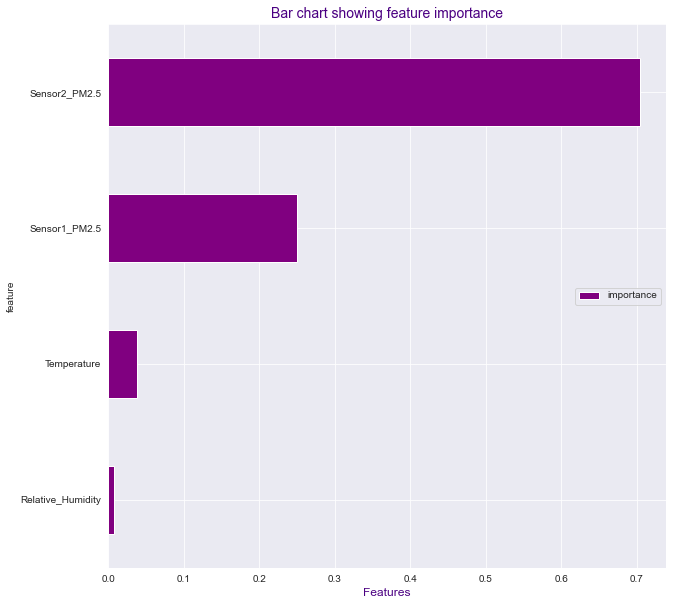

In [113]:
# Feature importance
impo_df = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10), color = 'purple')
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', color = 'indigo', fontsize = 14)
plt.xlabel('Features', fontsize = 12, color = 'indigo')
plt.show()

In [111]:

KNN.fit(X_train, y_train)

# Making predictions
y_pred = KNN.predict(X_test)

# Measuring the accuracy of the model
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print('\n')
print(f'{classification_report(y_test, y_pred)}')

Accuracy score: 0.9329404299503904


              precision    recall  f1-score   support

           0       0.94      0.95      0.95     65307
           1       0.92      0.90      0.91     38705

    accuracy                           0.93    104012
   macro avg       0.93      0.93      0.93    104012
weighted avg       0.93      0.93      0.93    104012



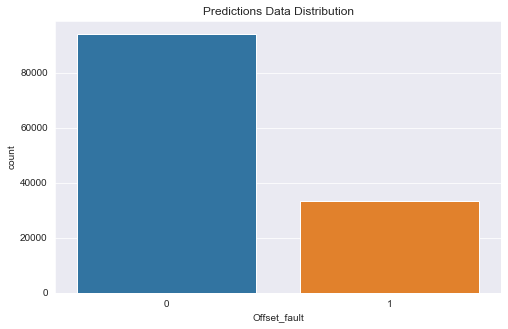

In [112]:
# Make prediction on the test set
test_df = test[train_feats]
predictions = KNN.predict(test_df)

# # Create a submission file
sub_file = SampleSubmission.copy()
sub_file.Offset_fault = predictions

# Check the distribution of your predictions
plt.figure(figsize=(8, 5))
sns.countplot(sub_file.Offset_fault)
plt.title('Predictions Data Distribution');

In [101]:
# Create file
sub_file.to_csv('Baseline1.csv', index = False)